In [111]:
# Source: Konstantin Sofeikov, https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95

In [123]:
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
import torch.nn.functional as F
import numpy as np

In [90]:
# load the data
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [91]:
# let's build a simple auto-encoder
mnist_trainset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

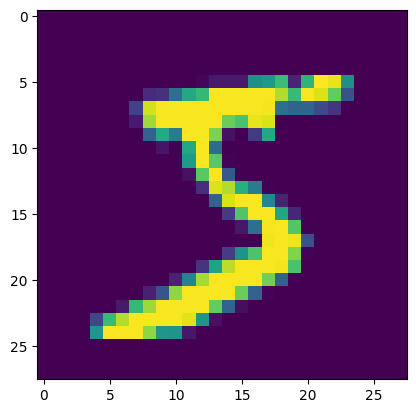

In [92]:
plt.imshow(mnist_trainset.data[0].view((28,28)))

In [93]:
X_train = mnist_trainset.data.view(-1, 784).float() / 255.0
X_test = mnist_trainset.data.view(-1, 784).float() / 255.0
Y_train = mnist_trainset.targets
Y_test = mnist_testset.targets

In [94]:
X_train.shape

torch.Size([60000, 784])

In [95]:
def show_images(images, labels):
    """
    Display a set of images and their labels using matplotlib.
    The first column of `images` should contain the image indices,
    and the second column should contain the flattened image pixels
    reshaped into 28x28 arrays.
    """
    # Extract the image indices and reshaped pixels
    pixels = images.reshape(-1, 28, 28)

    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=len(images), nrows=1, figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the image and its label
        axs[i].imshow(pixels[i], cmap="gray")
        axs[i].set_title("Label: {}".format(labels[i]))

        # Remove the tick marks and axis labels
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("Index: {}".format(i))

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

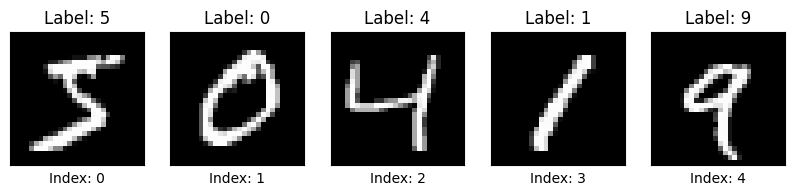

In [96]:
show_images(X_train[:5], Y_train[:5])

In [118]:
class AutoEncoder(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        
        # Set the number of hidden units
        self.num_hidden = n_hidden
        
        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),  # input size: 784, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, self.num_hidden),  # input size: 256, output size: num_hidden
            nn.ReLU(),  # apply the ReLU activation function
        )
        
        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),  # input size: num_hidden, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, 784),  # input size: 256, output size: 784
            nn.Sigmoid(),  # apply the sigmoid activation function to compress the output to a range of (0, 1)
        )

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Pass the encoded representation through the decoder
        decoded = self.decoder(encoded)
        # Return both the encoded representation and the reconstructed output
        return encoded, decoded
    
    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden)
            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z)
        # Return the generated samples
        return samples

In [173]:
learning_rate = 1e-3
batch_size = 32
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [174]:
# prepare for training

# Create the autoencoder model and optimizer
model = AutoEncoder(2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

# Define the loss function
criterion = nn.MSELoss()

# Create a DataLoader to handle batching of the training data
train_loader = torch.utils.data.DataLoader(
    X_train, batch_size=batch_size, shuffle=True
)

In [175]:
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        # Get a batch of training data and move it to the device
        data = data.to(device)

        # Forward pass
        encoded, decoded = model(data)

        # Compute the loss and perform backpropagation
        loss = criterion(decoded, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )

Epoch 1/10: loss=0.0537
Epoch 2/10: loss=0.0476
Epoch 3/10: loss=0.0453
Epoch 4/10: loss=0.0439
Epoch 5/10: loss=0.0430
Epoch 6/10: loss=0.0423
Epoch 7/10: loss=0.0418
Epoch 8/10: loss=0.0415
Epoch 9/10: loss=0.0411
Epoch 10/10: loss=0.0408


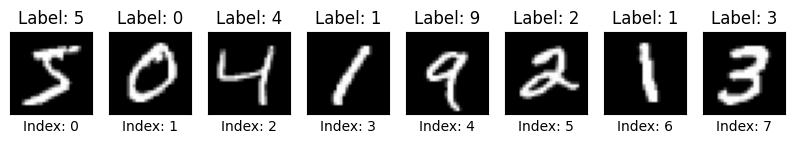

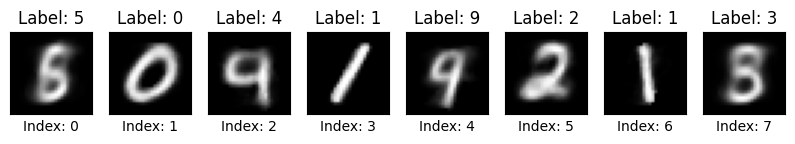

In [177]:
# show reconstruction for a few samples
ls = [model(X_train[i])[1].detach() for i in range(8)]
recons = torch.stack(ls, dim=0)
show_images(X_train[:8], Y_train[:8])
show_images(recons, Y_train[:8])

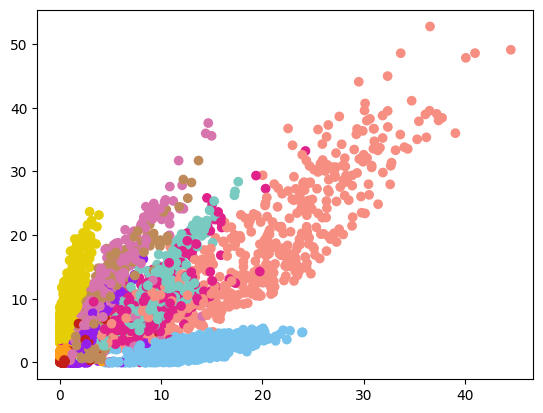

In [178]:
# plot t-sne of latent space
Z = [model(X_train[i])[0].detach() for i in range(X_train.shape[0])]
Z = torch.stack(Z, dim=0)
#Z_sne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(Z)
colormap=np.array(['#e6ce06', '#78c3ed', '#c31f16', '#d774ae', '#79cac1', '#bf8a5a', '#ff9e18', '#f78e82', '#961eea', '#e02189'])
plt.scatter(Z[:5000,0], Z[:5000,1], c=colormap[Y_train[:5000]])

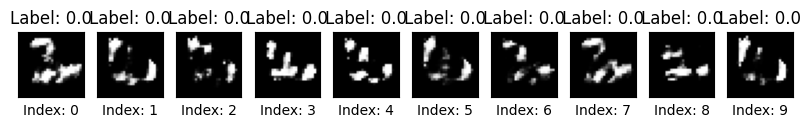

In [140]:
# sample from the latent space
Z = model.sample(num_samples=10)
show_images(Z, np.zeros(Z.shape[0]))

In [146]:
class VAE(AutoEncoder):
    def __init__(self, n_hidden):
        super().__init__(n_hidden)
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(z)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var


In [207]:
# Define a loss function that combines binary cross-entropy and Kullback-Leibler divergence
def loss_function(recon_x, x, mu, logvar):
    # Compute the binary cross-entropy loss between the reconstructed output and the input data
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Combine the two losses by adding them together and return the result
    return BCE + 3 * KLD

In [199]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [210]:
def train_vae(X_train, n_hidden, learning_rate=1e-3, num_epochs=10, batch_size=32):
    # Convert the training data to PyTorch tensors
    X_train = X_train.to(device)

    # Create the autoencoder model and optimizer
    model = VAE(n_hidden)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the loss function
    criterion = nn.MSELoss(reduction="sum")

    # Set the device to GPU if available, otherwise use CPU
    model.to(device)

    # Create a DataLoader to handle batching of the training data
    train_loader = torch.utils.data.DataLoader(
        X_train, batch_size=batch_size, shuffle=True
    )

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for _, data in enumerate(train_loader):
            # Get a batch of training data and move it to the device
            data = data.to(device)

            # Forward pass
            _, decoded, mu, log_var = model(data)

            # Compute the loss and perform backpropagation
#            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#            loss = criterion(decoded, data) + 3 * KLD
            loss = loss_function (decoded, data, mu, log_var)
            #print(f'{bce.item()=}, {kld.item()=}')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(train_loader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        )

    # Return the trained model
    return model

In [211]:
model_vae = train_vae(X_train=X_train, n_hidden=2, num_epochs=10)

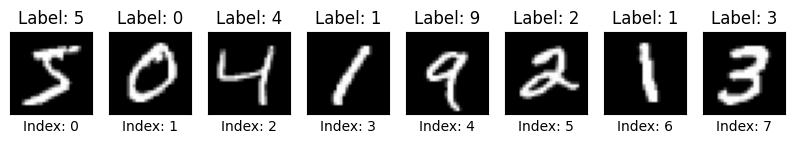

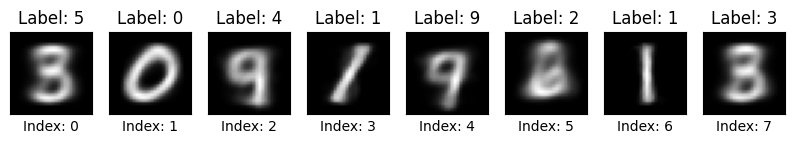

In [206]:
# show reconstruction for a few samples
ls = [model_vae(X_train[i])[1].detach() for i in range(8)]
recons = torch.stack(ls, dim=0)
show_images(X_train[:8], Y_train[:8])
show_images(recons, Y_train[:8])

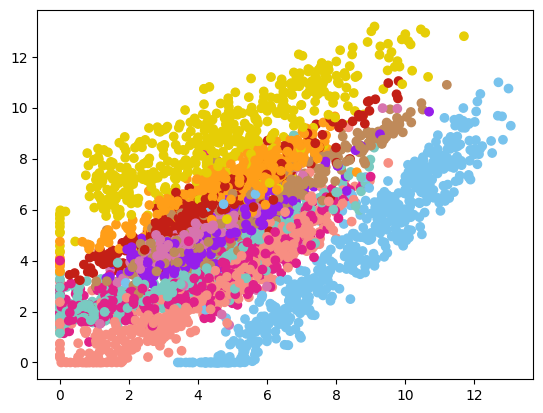

In [170]:
# plot t-sne of latent space
Z = [model_vae(X_train[i])[0].detach() for i in range(X_train.shape[0])]
Z = torch.stack(Z, dim=0)
#Z_sne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(Z)
colormap=np.array(['#e6ce06', '#78c3ed', '#c31f16', '#d774ae', '#79cac1', '#bf8a5a', '#ff9e18', '#f78e82', '#961eea', '#e02189'])
plt.scatter(Z[:5000,0], Z[:5000,1], c=colormap[Y_train[:5000]])

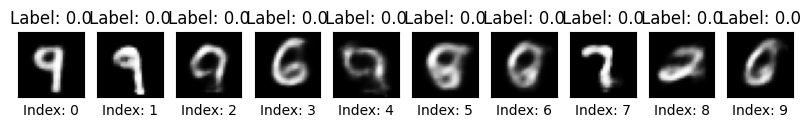

In [166]:
# sample from the latent space
Z = model_vae.sample(num_samples=10)
show_images(Z, np.zeros(Z.shape[0]))